# pandasでの前処理を高速化するTips集

# はじめに
当社にアルバイトに来ていた人（来春に新卒入社の予定）に「pandasを高速化するための情報は無いですか？」と尋ねられました。  
このパッケージの使い方を解説した記事は、Qiitaを始め、色々なところで書かれています。  
しかし、高速化に関する情報で思い当たるものが無かったため、「実践するしかないです」と、役に立たない返答をしてしまいました。  
そこで、この方を始め、来春（2019年4月）にデータアナリストまたはデータサイエンティストになる新卒へ向けて、pandasに関する私の経験をTips集にしてお伝えしたいと思います。

# 要約
- 前処理に時間が掛かると分析する時間が失われ、結果として、品質は落ちる。そのため、前処理は速くなければならない。
- 1件1件の処理はわずかな時間でも、レコード件数が1000万を超えるようなデータでは、全体を処理するのに想定以上に時間が掛かる。
- 高速化するために必要なことは次の4つ。
  - メモリを上限まで使わない
  - 扱うデータ量を減らす
  - `for`内で`DataFrame`の処理は使わない
  - `for`の代わりに`merge`をうまく使う

# 対象読者
本記事が想定している読者層は、次の3つのいずれかに該当する方々です。  

- 学部生や大学院生で将来データ分析を仕事にしたい
- アルバイトやインターンとして分析案件に携わっている
- すでに企業から内定をもらっていて、アナリストまたはデータサイエンティストとして就業予定

## 前提にするスキル
この記事では、以下について基本的な知識があることを想定しています。  
これらの使い方は本記事では説明しませんので、ご注意ください。

- python
- pandas

# なぜ、前処理の高速化が必要なのか？
それは分析の品質の低下を招くからです。  
なぜなのでしょうか？  
ここでは、クライアント企業から機械学習による分析を受託した場合を想定して説明します。  
一般的に、分析プロジェクトは次のような流れで進んでいきます。  

1. 分析要件の確定
2. データ受領
3. 前処理
4. モデル構築
5. モデル評価
6. 報告書作成
7. 納品

本記事では前処理に主眼を置いていますので、このステップの作業を深堀して見てみると、

- データクリーニング  
  欠測、ノイズ、外れ値の処理
- データの統合  
  受領したデータから必要なデータを集めて、紐付ける
- データ変換  
  モデルに必要なフォーマットに変換する行為で、次のようなものがある
  - 正規化  
    数値データを0〜1までの範囲のデータに変換する    
  - 集約
    いくつかの特徴量を1つにまとめて、新たな特徴量を作る
  - 一般化
    低レベルの属性をより一般的なものに変換する
  - データ削減
    上記の操作で不要になった特徴量を削除する

（参考: [Data Preprocessing and Data Wrangling in Machine Learning and Deep Learning](https://viblo.asia/p/data-preprocessing-and-data-wrangling-in-machine-learning-and-deep-learning-Qpmlenrk5rd)）  

といった項目があります。盛り沢山ですね。  

データクリーニングは個別に対応する必要があり、労力が必要なパートです。  
平均値や中央値などで一括処理してしまう事もできますが、データがバイアスを持つ原因になり、一般的に、予測精度は下がります。  

データの統合は、ミスを犯しやすく、処理が重たいパートです。  
単純に`merge`を使って処理できればいいですが、そう簡単には行きません。  
モデルに使いたい特徴量を作るためには、1回の`merge`だけでは済まない複雑な紐付けを要求されることも頻繁にあります。  
また、クライアントから「このように紐付けるの直感的に正しい」とお教えいただくこともありますが、それをコードに落とし込むとなると、なかなか複雑な場合もあります。  
だからといって、`for`文で紐付けるコードを書いてしまうと、2〜3時間実行し続けても終わらない処理が簡単に出来上がってしまいます。  
本記事では、このような場合にどのようなコードを書くと速いのかを扱っていきます。



それは、高速で動くコードを意識して書かなければ、数時間実行しても終わらないプログラムが簡単にできてしまうからです。  
前処理は分析している時間の7〜8割を占めると言われており、これは筆者の経験でも、その通りだと言えます。  
この段階で時間が掛かり過ぎてしまうと、モデル構築に使える時間は少なくなります。  
特に機械学習を使った案件では、トレーニングやハイパーパラメータのチューニングにも時間が掛かるため、十分な検証を行うことができなくなり、結果として分析の質は低下します。  
これらを避けるためにも、

# 高速化で求められるオーダーは？
高速化をどの程度早くしたら良いでしょうか？  
ここでは、1レコードあたりに掛かる処理時間を一定にして、レコード数が変化すると合計処理時間がどのように変わるのか見ていきます。

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

レコード数`NUMBER_OF_RECORDS`と1レコードあたりに掛かる処理時間`RUN_TIME_SEC`を以下のように設定します。

In [2]:
NUMBER_OF_RECORDS = [1000, 10000, 100000, 1000000, 10000000]
RUN_TIME_SEC = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

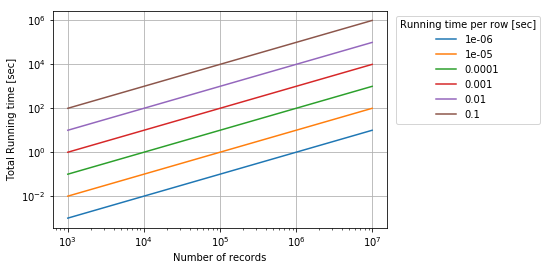

In [3]:
records = []
run_time_per_row = []
run_time_total = []
for run_time in RUN_TIME_SEC:
    run_time_per_row.extend([run_time] * len(NUMBER_OF_RECORDS))
    records.extend(NUMBER_OF_RECORDS)
    run_time_total.extend([n * run_time for n in NUMBER_OF_RECORDS])

tmp = pd.DataFrame(
    data={
        'run_time_per_row': run_time_per_row,
        'records': records,
        'run_time_total': run_time_total
    },
    columns=['run_time_per_row', 'records', 'run_time_total']
)
run_time_data = tmp.set_index(['records', 'run_time_per_row']).unstack('run_time_per_row')

run_time_data.run_time_total.plot(grid=True)
plt.xlabel('Number of records')
plt.ylabel('Total Running time [sec]')
plt.legend(title='Running time per row [sec]', bbox_to_anchor=(1.01,1))
plt.xscale('log')
plt.yscale('log')
plt.show()

仮に10万レコードのデータを1レコードあたりに0.1秒掛かる処理を適用した場合、上のグラフによれば、すべての処理が終了するまでに10,000秒（約2時間47分）を要します。  
さらにレコード数が増えて1000万件になった場合は、1,000,000秒（約11.6日）掛かることになります。  
現場でデータ分析をしていると、このサイズのデータを扱うことは良くあるので、効率よく短時間で処理できなければなりません。  
たった1回だけの書き捨てのスクリプトであれば、1〜2時間待ってもいいかもしれません。  
しかし、ほとんどの場合はデバックが必要ですし、特徴量を抽出し直す等で同じロジックを回すことになるかもしれません。  
その度に1〜2時間と待っていたら、分析する時間は失われてしまいます。  
前処理を高速化すべき理由はここにあります。  

さて、それでは1レコードあたりの処理時間はどのくらいを目指すと良いのでしょうか？  
ここには明確な基準は存在しませんので、あくまでも筆者の基準ですが、1つの処理で待てる時間は3分程度です。  
これ以上掛かる部分がある場合は一旦処理を停止して、ロジックを見直すようにしています。  

# 使用するテストデータ

テストデータは`scikit-learn.datasets`の`california_housing`の特徴量を使います。  
データの概略は以下の通りです。  
データの詳細は[scikit-learnのCalifornia Housing dataset](https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset)を参照してください。  

- サンプルサイズ：20640
- 特徴量の数：8

各特徴量の概略

|Feature    |Description                |
|:----------|:--------------------------|
|MedInc     |median income in block     |
|HouseAge   |median house age in block  |
|AveRooms   |average number of rooms    |
|AveBedrms  |average number of bedrooms |
|Population |block population           |
|AveOccup   |average house occupancy    |
|Latitude   |house block latitude       |
|Longitude  |house block longitude      |

In [4]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

fetched_data = fetch_california_housing()
california_housing = pd.DataFrame(
    data=fetched_data['data'],
    columns=fetched_data['feature_names']
)
california_housing.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [5]:
california_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


# 1. 既存のレコードによって値を変えて新しい列をDataFrameに追加したい
ここでは、`HouseAge`を`young`, `middle`, `old`の3階級で分類した列を追加します。  
`young`と`middle`の分岐、`middle`と`old`の分岐はそれぞれ`quantile`で1/3と2/3を計算した値を使います。

In [6]:
california_housing.HouseAge.quantile([1/3, 2/3])

0.333333    22.0
0.666667    35.0
Name: HouseAge, dtype: float64

In [7]:
LOWER_SPLIT = 22.0
UPPER_SPLIT = 35.0

AGE_LABEL_YOUNG = 'young'
AGE_LABEL_MIDDLE = 'middle'
AGE_LABEL_OLD = 'old'

## 方法1　for文で新たな列を作る
まずはfor文で1行ずつ処理する場合を検証します。  
この方法は、プログラミング初心者に多く見られる書き方です。  
分かりやすいのですが、DataFrameの操作は重たいので、20,640行のデータを処理するのに21.3秒（1行あたり0.001秒）掛かっています。  
もしこのままサンプルサイズが1000万行のデータを処理するとなると、上のグラフから、10000秒（約2時間47分）必要になります。  

In [8]:
def method1(data):
    _data = data.copy()
    _data.loc[:, 'HouseAgeClass'] = None
    for i in range(len(_data)):
        house_age = _data.iloc[i, :]['HouseAge']
        if house_age < LOWER_SPLIT: 
            _data.iloc[i, -1] = AGE_LABEL_YOUNG
        elif LOWER_SPLIT <= house_age < UPPER_SPLIT:
            _data.iloc[i, -1] = AGE_LABEL_MIDDLE
        else:
            _data.iloc[i, -1] = AGE_LABEL_OLD
    return _data

In [9]:
method1(california_housing).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HouseAgeClass
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,old
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,young
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,old
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,old
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,old


## 方法2 DataFrameのスライシングで新たな列を作る
次はDataFrameのスライシングを使って新たな列を作る方法です。  
Rではお馴染みな方法なので、RからPandasに乗り換えたユーザーにとっては分かりやすいのではないでしょうか？  
私もPandasに乗り換えた当初はこの方法で列を作成していましたが、お世辞にも見やすいコードとは言えないので、最近はこの後で紹介するmapメソッドによる方法を使うことにしています。  
処理速度はそれほど悪くなく8.41ms（1行あたり0.41μs）となります。  
仮に1000万行のデータを処理する場合は4.07sしか掛かりません。  
`method2`関数内の1行目`_data = data.copy()`で余分な時間が掛かっていることを考慮しても、悪くないと言えます。

In [10]:
def method2(data):
    _data = data.copy()    # 元データに影響を与えないようにする
    _data.loc[(_data.HouseAge < LOWER_SPLIT), 'HouseAgeClass'] = AGE_LABEL_YOUNG
    _data.loc[(_data.HouseAge >= LOWER_SPLIT) & (_data.HouseAge < UPPER_SPLIT), 'HouseAgeClass'] = AGE_LABEL_MIDDLE
    _data.loc[(_data.HouseAge >= UPPER_SPLIT), 'HouseAgeClass'] = AGE_LABEL_OLD
    return _data

In [11]:
method2(california_housing).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HouseAgeClass
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,old
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,young
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,old
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,old
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,old


## 方法3 mapメソッドを使って新たな列を作る
最後にDataFrameのmapメソッドを使って作る方法です。  
ヘルパー関数（この例では`create_house_age_class`）を定義する必要がありますが、可読性が良く、ヘルパー関数を修正するだけでクラス分けの変更ができることが利点です。  
処理速度も4.19ms（1行あたり0.2μs）と先に紹介した2つの方法よりも速いです。  
仮に1000万行のデータを処理する場合は2.03sしか掛かりません。

In [12]:
def method3(data):
    def create_house_age_class(age):
        if age < LOWER_SPLIT:
            return AGE_LABEL_YOUNG
        elif (LOWER_SPLIT <= age) and (age < UPPER_SPLIT):
            return AGE_LABEL_MIDDLE
        else:
            return AGE_LABEL_OLD

    _data = data.copy()
    _data.loc[:, 'HousingAgeClass'] = _data.HouseAge.map(create_house_age_class)
    return _data

In [13]:
method3(california_housing).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HousingAgeClass
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,old
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,young
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,old
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,old
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,old


## 検証結果
### 方法1〜3を比較結果

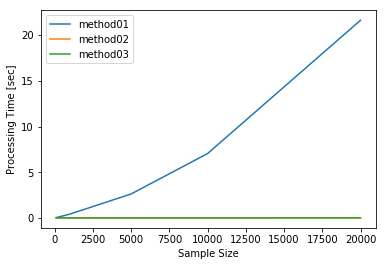

In [14]:
from utilities.process_time import PandasProcessTimeMeasure

process_time_measure = PandasProcessTimeMeasure(
    data=california_housing,
    sample_sizes=[100, 500, 1000, 5000, 10000, 20000]
)
process_time_measure.set_method(name='method01', method=method1)
process_time_measure.set_method(name='method02', method=method2)
process_time_measure.set_method(name='method03', method=method3)
process_time_measure.measure_process_time_for_each_sample_sizes()
process_time_measure.plot_process_time()

In [15]:
process_time_measure.process_time

,method01,method02,method03
sample_size,,,
100,0.038640,0.004645,0.000851
500,0.201697,0.004845,0.000944
1000,0.419440,0.004602,0.001031
5000,2.619622,0.005373,0.001831
10000,7.042201,0.006180,0.002811
20000,21.625318,0.008480,0.005633


In [16]:
del process_time_measure

### 方法2と方法3の処理時間は行数に対して線形に増えるのか？
方法2と3の処理時間は行数に対して線形に増えると言えるのでしょうか？

In [17]:
data = pd.concat(objs=[california_housing]*500, axis=0)
data.reset_index(drop=True, inplace=True)
data.shape

(10320000, 8)

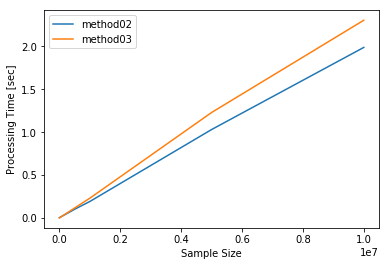

In [18]:
from utilities.process_time import PandasProcessTimeMeasure

process_time_measure = PandasProcessTimeMeasure(
    data=data,
    sample_sizes=[100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]
)
process_time_measure.set_method(name='method02', method=method2)
process_time_measure.set_method(name='method03', method=method3)
process_time_measure.measure_process_time_for_each_sample_sizes()
process_time_measure.plot_process_time()

In [19]:
process_time_measure.process_time

,method02,method03
sample_size,,
100,0.004440,0.000823
500,0.004472,0.000891
1000,0.004601,0.000980
5000,0.005166,0.001705
10000,0.005774,0.002586
50000,0.013529,0.012015
100000,0.023419,0.023697
500000,0.101577,0.116434
1000000,0.192417,0.230766


In [20]:
del process_time_measure

# 2. 複数のカラムによって値を変えて新しい列をDataFrameに追加したい